In [4]:
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

from rbase import *

In [2]:
col_names = ['pressure', 'height', 'temperature',
             'dewpoint', 'direction', 'speed']

# f = get_test_data('may4_sounding.txt', as_file_obj=False)
f = "data/may4_sounding.txt"
df = pd.read_fwf(f,
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all'
               ).reset_index(drop=True)
df.head()

,pressure,height,temperature,dewpoint,direction,speed
0,959.0,345,22.2,19.0,160,18
1,931.3,610,20.2,17.5,165,40
2,925.0,671,19.8,17.1,165,38
3,899.3,914,18.4,16.9,175,39
4,892.0,984,18.0,16.8,178,39


In [3]:
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)


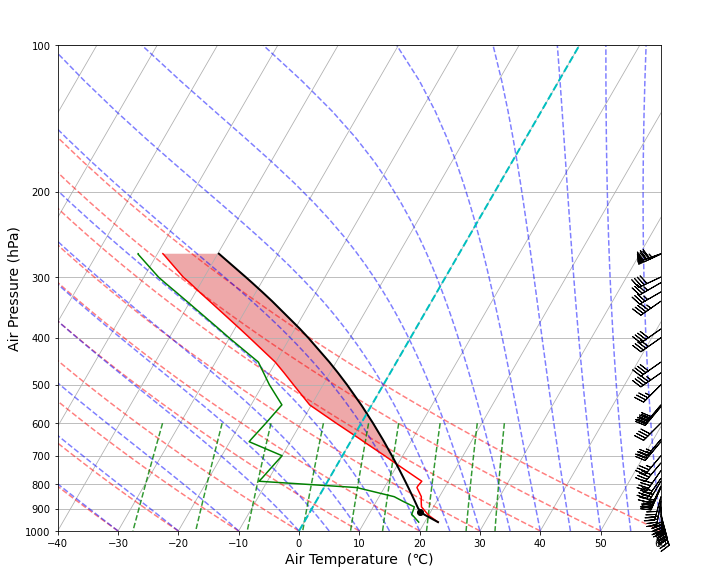

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def plot_skewT(rotation = 15*3):
  fig = plt.figure(figsize = (9, 7), constrained_layout=True)
  # add_metpy_logo(fig, 115, 100)
  # rotation = 15*3
  skew = SkewT(fig, rotation=rotation)

  skew.plot(p, T, 'r')
  skew.plot(p, Td, 'g')
  skew.plot_barbs(p, u, v)
  skew.ax.set_ylim(1000, 100)
  skew.ax.set_xlim(-40, 60)

  # Calculate LCL height and plot as black dot. Because `p`'s first value is
  # ~1000 mb and its last value is ~250 mb, the `0` index is selected for `p`,
  # `T`, and `Td` to lift the parcel from the surface. If `p` was inverted, i.e.
  # start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
  # should be selected.
  lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
  skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

  # Calculate full parcel profile and add to plot as black line
  # 这里是理论过程，先
  prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
  skew.plot(p, prof, 'k', linewidth=2)

  # Shade areas of CAPE and CIN
  skew.shade_cin(p, T, prof, Td)
  skew.shade_cape(p, T, prof)

  # slanted line at constant T -- in this case the 0 isotherm
  skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

  # Add the relevant special lines
  skew.plot_dry_adiabats()
  skew.plot_moist_adiabats()
  skew.plot_mixing_lines()

  # plt.show()
  plt.xlabel('Air Temperature  (℃)', fontsize=14)
  plt.ylabel('Air Pressure (hPa)', fontsize=14)
  outfile = "lnP_T_deg%s.pdf" % (rotation)
  write_fig(outfile, 10, 8)


plot_skewT(rotation=30)